In [1]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
import pandas as pd

input_shape = (224, 224, 3)

In [2]:
mobilenet_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
mobilenet_model.trainable = False
mobilenet_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [3]:
layers = [(layer, layer.name, layer.trainable) for layer in mobilenet_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,False
1,<tensorflow.python.keras.layers.convolutional....,Conv1_pad,False
2,<tensorflow.python.keras.layers.convolutional....,Conv1,False
3,<tensorflow.python.keras.layers.normalization....,bn_Conv1,False
4,<tensorflow.python.keras.layers.advanced_activ...,Conv1_relu,False
...,...,...,...
150,<tensorflow.python.keras.layers.convolutional....,block_16_project,False
151,<tensorflow.python.keras.layers.normalization....,block_16_project_BN,False
152,<tensorflow.python.keras.layers.convolutional....,Conv_1,False
153,<tensorflow.python.keras.layers.normalization....,Conv_1_bn,False


In [4]:
import os
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   zoom_range=0.3, 
                                   rotation_range=50,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

dataset_path = 'dataset'
train_set_path = os.path.join(dataset_path, 'train')
val_set_path = os.path.join(dataset_path, 'test')
BATCH_SIZE = 32
TARGET_SIZE = input_shape[:2]
train_generator = train_datagen.flow_from_directory(train_set_path,
                                                 target_size = TARGET_SIZE,
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

val_generator = val_datagen.flow_from_directory(val_set_path,
                                                target_size = TARGET_SIZE,
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'categorical')
model = Sequential()
model.add(mobilenet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.06, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

EPOCHS = 16
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_generator.n // BATCH_SIZE, 
                              epochs=EPOCHS,
                              validation_data=val_generator, 
                              validation_steps=val_generator.n // BATCH_SIZE, 
                              verbose=1)

Found 3061 images belonging to 2 classes.
Found 791 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 95 steps, validate for 24 steps
Epoch 1/16
95/95 [==============================] - 37s 387ms/step - loss: 2.9589 - accuracy: 0.8389 - val_loss: 11.1120 

In [6]:
model.save('Fresh_Rotten_Fruits_MobileNetV2_Transfer_Learning.h5')

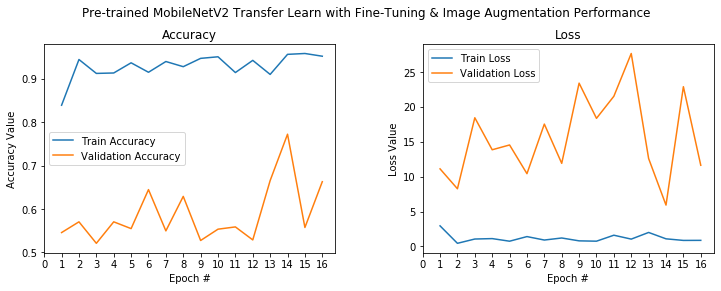

In [7]:
import matplotlib.pyplot as plt
import numpy as np

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained MobileNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")